---
title: "Snowflake Storage Cortex Forecast Example"
date: "09/01/2024"
format:
    html:
        code-fold: False
        output: False
---

# Overview

In [1]:
%load_ext autoreload
%autoreload 2

# Example Useage

In [2]:
#| skip
from snowflake.snowpark.version import VERSION
from cortex_forecast.forecast import SnowflakeMLForecast
import os

## Create Snowflake Connection Using SnowflakeMLForecast


> Note: Make sure that you create a yaml file that you would like to so that the SnowflakeMLForecast can read the connection information from it and be able to build your forecast.

In [3]:
#| skip
forecast_model = SnowflakeMLForecast(
   config='./cortex_forecast/files/yaml/storage_forecast_config.yaml',
    connection_config={
        'user': os.getenv('SNOWFLAKE_USER'),
        'password': os.getenv('SNOWFLAKE_PASSWORD'),
        'account': os.getenv('SNOWFLAKE_ACCOUNT'),
        'database': 'CORTEX',
        'warehouse': 'CORTEX_WH',
        'schema': 'DEV',
        'role': 'CORTEX_USER_ROLE'  # Use the desired role
    },
    is_streamlit=False
)

snowflake_environment = forecast_model.session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION
print('\nConnection Established with the following parameters:')
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0], snowpark_version[1], snowpark_version[2]))


Connection Established with the following parameters:
Snowflake version           : 8.33.1
Snowpark for Python version : 1.18.0


### Create a Training Table

In [4]:
#| skip
# Create Training Data
training_days = 365

forecast_model.session.sql(f'''CREATE OR REPLACE TABLE storage_usage_train AS
    SELECT 
        TO_TIMESTAMP_NTZ(usage_date) AS usage_date,
        storage_bytes / POWER(1024, 3) AS storage_gb
    FROM 
    (
        SELECT * 
            FROM snowflake.account_usage.storage_usage
            WHERE usage_date < CURRENT_DATE()
    )
    WHERE TO_TIMESTAMP_NTZ(usage_date) > DATEADD(day, -{training_days}, CURRENT_DATE())
''').collect()
forecast_model.session.sql('SELECT * FROM storage_usage_train ORDER BY usage_date DESC LIMIT 10').show()

--------------------------------------------
|"USAGE_DATE"         |"STORAGE_GB"        |
--------------------------------------------
|2024-09-09 00:00:00  |279.30466333497316  |
|2024-09-08 00:00:00  |279.2785071162507   |
|2024-09-07 00:00:00  |279.278612091206    |
|2024-09-06 00:00:00  |280.4016931857914   |
|2024-09-05 00:00:00  |279.9979070248082   |
|2024-09-04 00:00:00  |273.75833379570395  |
|2024-09-03 00:00:00  |267.7940624393523   |
|2024-09-02 00:00:00  |265.5218228260055   |
|2024-09-01 00:00:00  |265.05640272889286  |
|2024-08-31 00:00:00  |265.0566206406802   |
--------------------------------------------



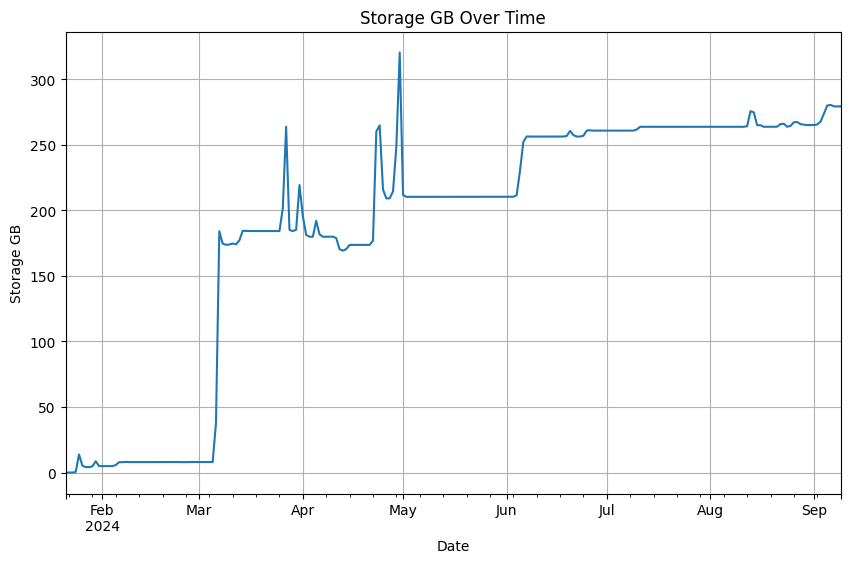

In [5]:
#| skip
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = forecast_model.session.sql('SELECT * FROM storage_usage_train ORDER BY usage_date').to_pandas()
df.head()
df = df.set_index('USAGE_DATE')
df['STORAGE_GB'].plot(figsize=(10, 6), title='Storage GB Over Time')

# Show the plot
plt.xlabel('Date')
plt.ylabel('Storage GB')
plt.grid(True)
plt.show()


### Train a Model

> This will use what is inside of the yaml file that you created that you passed over to the SnowflakeMLForecast object


In [6]:
#| skip
# Run Forecast
forecast_data = forecast_model.create_and_run_forecast()
forecast_data.head()

Attempting to create tag: environment
Tag 'environment' already exists.
Attempting to create tag: team
Tag 'team' already exists.
Step 1/4: Creating training table...
Generated SQL:

        CREATE OR REPLACE TABLE SNOWPARK_TEMP_TABLE_I4YIECO9KI AS
        SELECT TO_TIMESTAMP_NTZ(usage_date) AS usage_date, CAST(storage_gb AS FLOAT) AS storage_gb, * EXCLUDE (usage_date, storage_gb)
        FROM CORTEX.DEV.storage_usage_train
        
            WHERE TO_TIMESTAMP_NTZ(usage_date) 
            BETWEEN 
            DATEADD(day, -365, (SELECT MAX(usage_date) FROM CORTEX.DEV.storage_usage_train)) 
            AND 
            (SELECT MAX(usage_date) FROM CORTEX.DEV.storage_usage_train)
            ;
Step 2/4: Creating forecast model...
Generated SQL:

        CREATE OR REPLACE SNOWFLAKE.ML.FORECAST CORTEX.DEV.my_forecast_model_20240910_emhjl(
            INPUT_DATA => SYSTEM$REFERENCE('TABLE', 'SNOWPARK_TEMP_TABLE_I4YIECO9KI'),
            TIMESTAMP_COLNAME => 'usage_date',
            TARG

,USAGE_DATE,FORECAST,LOWER_BOUND,UPPER_BOUND,MODEL_NAME,CREATION_DATE,MODEL_COMMENT
0,2024-09-10,279.137226,273.698104,284.576348,my_forecast_model_20240910_emhjl,2024-09-10 17:52:01.944000-07:00,Forecast model for predicting sales trends.
1,2024-09-11,279.912494,272.220414,287.604574,my_forecast_model_20240910_emhjl,2024-09-10 17:52:01.944000-07:00,Forecast model for predicting sales trends.
2,2024-09-12,281.286666,271.865831,290.707501,my_forecast_model_20240910_emhjl,2024-09-10 17:52:01.944000-07:00,Forecast model for predicting sales trends.
3,2024-09-13,280.569576,269.691332,291.447819,my_forecast_model_20240910_emhjl,2024-09-10 17:52:01.944000-07:00,Forecast model for predicting sales trends.
4,2024-09-14,281.724481,269.562235,293.886727,my_forecast_model_20240910_emhjl,2024-09-10 17:52:01.944000-07:00,Forecast model for predicting sales trends.


In [7]:
forecast_model.generate_forecast_and_visualization(show_historical=True)

Executing forecast query:

            SELECT *
            FROM CORTEX.DEV.storage_forecast_results
            WHERE model_name = 'my_forecast_model_20240910_emhjl'
            ORDER BY usage_date DESC
        
Forecast data preview (last 5 rows):


,USAGE_DATE,FORECAST,LOWER_BOUND,UPPER_BOUND,MODEL_NAME,CREATION_DATE,MODEL_COMMENT
25,2024-09-14,281.724481,269.562235,293.886727,my_forecast_model_20240910_emhjl,2024-09-10 17:52:01.944000-07:00,Forecast model for predicting sales trends.
26,2024-09-13,280.569576,269.691332,291.447819,my_forecast_model_20240910_emhjl,2024-09-10 17:52:01.944000-07:00,Forecast model for predicting sales trends.
27,2024-09-12,281.286666,271.865831,290.707501,my_forecast_model_20240910_emhjl,2024-09-10 17:52:01.944000-07:00,Forecast model for predicting sales trends.
28,2024-09-11,279.912494,272.220414,287.604574,my_forecast_model_20240910_emhjl,2024-09-10 17:52:01.944000-07:00,Forecast model for predicting sales trends.
29,2024-09-10,279.137226,273.698104,284.576348,my_forecast_model_20240910_emhjl,2024-09-10 17:52:01.944000-07:00,Forecast model for predicting sales trends.


Executing historic actuals query:

            SELECT usage_date, storage_gb
            FROM CORTEX.DEV.storage_usage_train
            ORDER BY usage_date DESC
            LIMIT 21
            
Historical data preview (last 5 rows):


,USAGE_DATE,STORAGE_GB
16,2024-08-24,263.740104
17,2024-08-23,266.048814
18,2024-08-22,265.802130
19,2024-08-21,263.841009
20,2024-08-20,263.743386


Getting historical max date
Max historical date: 2024-09-09 00:00:00
Combined data preview (last 5 rows):


,USAGE_DATE,TYPE,VALUE_TYPE,VOLUME
127,2024-09-14,Forecast,UPPER_BOUND,293.886727
128,2024-09-13,Forecast,UPPER_BOUND,291.447819
129,2024-09-12,Forecast,UPPER_BOUND,290.707501
130,2024-09-11,Forecast,UPPER_BOUND,287.604574
131,2024-09-10,Forecast,UPPER_BOUND,284.576348


alt.LayerChart(...)

Top 10 Feature Importances


alt.Chart(...)

,SERIES,RANK,FEATURE_NAME,SCORE,FEATURE_TYPE
0,None,1,lag7,0.10,derived_from_endogenous
1,None,2,aggregated_endogenous_trend_features,0.08,derived_from_endogenous
2,None,3,lag14,0.08,derived_from_endogenous
3,None,4,lag28,0.07,derived_from_endogenous
4,None,5,lag91,0.06,derived_from_endogenous
5,None,6,lag63,0.06,derived_from_endogenous
6,None,7,lag56,0.06,derived_from_endogenous
7,None,8,lag49,0.06,derived_from_endogenous
13,None,14,lag98,0.05,derived_from_endogenous
12,None,13,lag21,0.05,derived_from_endogenous


Underlying Model Metrics


,SERIES,ERROR_METRIC,METRIC_VALUE,STANDARD_DEVIATION,LOGS
0,None,MAE,2.827,0.697,None
1,None,MAPE,0.011,0.003,None
2,None,MDA,0.636,0.064,None
3,None,SMAPE,0.010,0.003,None
4,None,COVERAGE_INTERVAL=0.95,1.000,0.000,None
5,None,WINKLER_ALPHA=0.05,62.387,56.201,None
6,None,MSE,21.525,18.611,None
